# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Setup](#Setup)
* [Alpha](#Alpha)
* [Discussion](#Discussion)

# Introduction

This is a post hoc tuning after seeing disappointing holdout results. We dropped ridge earlier for simplicity and speed, but now it's back in.

Since I'm close to wrapping up at this point, we'll do a quick tune and won't stop to evaluate too much.

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2022)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd
from scipy.stats import loguniform

# utility
from copy import deepcopy
from gc import collect as gc_collect

# faster sklearn
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

import swifter

# typing
from typing import Dict, List, Sequence

# other sklearn
from sklearn.calibration import CalibratedClassifierCV
from sklearn.linear_model import RidgeClassifier
from sklearn.model_selection import RandomizedSearchCV, StratifiedGroupKFold

# params
from scipy.stats import loguniform, uniform

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline

sns.set_context("notebook")

# full display of rows and columns
pd.set_option("display.max_columns", None)
pd.set_option("display.max_colwidth", None)
pd.set_option("display.max_rows", None)

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 4.3 s


In [4]:
# Location of pre-final labels and features
FEATURES_FOLDER = (
    "../24.0-mic-train_new_prototypes_with_simplified_pipeline_and_no_song_data"
)

# Location where this notebook will output
DATA_OUT_FOLDER = "./tune_ridge"

_ = gc_collect()

time: 127 ms


# Setup

In [5]:
def load_labels() -> pd.DataFrame:
    """Load just the labels"""
    return pd.read_feather(f"{FEATURES_FOLDER}/simplified_labels.feather").set_index(
        "id"
    )


def load_data() -> pd.DataFrame:
    """Loads the FRILL-based features"""
    df = pd.read_feather("./scaled_features_ready_for_selection.feather").set_index(
        "id"
    )
    df.columns = df.columns.astype(str)
    return df


data = load_data()
labels = load_labels()
assert all(data.index == labels.index)
assert len(data) < 86000
y_true = labels.valence
_ = gc_collect()

time: 239 ms


In [6]:
data.info()
labels.info()

<class 'pandas.core.frame.DataFrame'>
UInt64Index: 85740 entries, 0 to 87363
Data columns (total 14 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   LDA1                     85740 non-null  float64
 1   LDA2                     85740 non-null  float64
 2   ocSVM_sgdlinear_neg      85740 non-null  float64
 3   ocSVM_sgdlinear_neu      85740 non-null  float64
 4   ocSVM_sgdlinear_pos      85740 non-null  float64
 5   LDA-LOF_neg_20           85740 non-null  float64
 6   LDA-LOF_neu_20           85740 non-null  float64
 7   LDA-LOF_pos_20           85740 non-null  float64
 8   LDA-ocSVM_rbf_neg        85740 non-null  float64
 9   LDA-ocSVM_rbf_neu        85740 non-null  float64
 10  LDA-ocSVM_rbf_pos        85740 non-null  float64
 11  LDA-ocSVM_sgdlinear_neg  85740 non-null  float64
 12  LDA-ocSVM_sgdlinear_neu  85740 non-null  float64
 13  LDA-ocSVM_sgdlinear_pos  85740 non-null  float64
dtypes: float64(14)
memory

# Strata

In [7]:
N_SPLITS = 8

# fields are concatentated for quick permutation omitting non-existent combos
strata = labels.loc[
    :, ["source", "speaker_gender", "emo", "valence", "lang1", "length"]
]
strata.valence = strata.valence.astype(str)
strata = strata.swifter.apply("".join, axis=1)

Dask Apply: 100%|██████████| 16/16 [00:03<00:00,  4.31it/s]


time: 7.86 s


In [8]:
# utility function for identifying strata with only i occurences
def get_solo(i: int, strata_: pd.Series) -> np.ndarray:
    """Given a series of stratum memberships, return a shuffled array of strata with only i members."""
    return np.unique(
        strata_.loc[
            strata_.isin(
                (strata_counts := strata_.value_counts())
                .where(strata_counts == i)
                .dropna()
                .index
            )
        ]
        .sample(frac=1, random_state=SEED)
        .values
    )


# get solos, print stuff
def get_onlys(
    strata_: pd.Series, print_me: str = "", n_splits: int = N_SPLITS
) -> List[Dict[int, np.ndarray]]:
    """Optinally prints something and returns calls of get_solo on strata_ in a list"""
    print(print_me)
    solos = []
    for i in range(1, n_splits):
        solo: np.ndarray = get_solo(i, strata_)
        print(f"only {i}:", (_ := solo.size))
        if _:  # >= 1 strata with only i samples
            solos.append({i: solo})
    return solos


def process_strata(strata: pd.Series, n_splits: int = N_SPLITS) -> pd.Series:
    """Corrects strata membership column according to n_splits"""

    count = get_onlys_calls = 0

    while onlys := get_onlys(
        strata,
        print_me=f"merge passes performed: {get_onlys_calls}",
        n_splits=n_splits,
    ):
        get_onlys_calls += 1
        if len(onlys) == 1:
            last = onlys[0]
            strata_to_merge: np.ndarray = list(last.values())[0]
            only_key = list(last.keys())[0]
            tuplet_size = n_splits // only_key + (1 if n_splits % only_key else 0)
            # perform tuplet merge
            interval = len(strata_to_merge) // n_splits
            for strata_tuplet in zip(
                *[
                    strata_to_merge[interval * i : interval * (i + 1)]
                    for i in range(tuplet_size)
                ]
            ):
                strata = strata.replace(strata_tuplet, f"stratum_group_{count}")
                count += 1
            remainder = strata_to_merge[tuplet_size * interval :]
            if len(remainder) == 1:
                # process remainder unmatched
                n = n_splits
                strata_counts = strata.value_counts()
                while not (candidates := strata_counts.loc[strata_counts == n]).size:
                    n += 1
                strata = strata.replace(
                    [remainder[0], candidates.sample(n=1, random_state=SEED).index[0]],
                    f"stratum_group_{count}",
                )
                count += 1
            else:
                # self-pair last
                remainder = remainder.tolist()
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
        else:
            pop_onlys = lambda _: list(onlys.pop(_).values())[0].tolist()
            while len(onlys) >= 2:
                # pop the ends
                shortside = pop_onlys(0)
                longside = pop_onlys(-1)
                # merge until one end empty
                while shortside and longside:
                    strata = strata.replace(
                        (shortside.pop(), longside.pop()), f"stratum_group_{count}"
                    )
                    count += 1
            if onlys:
                # self-pair middle
                remainder = pop_onlys(0)
                while len(remainder) >= 2:
                    strata = strata.replace(
                        (remainder.pop(), remainder.pop()), f"stratum_group_{count}"
                    )
                    count += 1
    return strata


_ = gc_collect()

time: 172 ms


In [9]:
STRATA = process_strata(strata, n_splits=N_SPLITS)
STRATA.value_counts()
cross_validator = lambda: StratifiedGroupKFold(
    n_splits=N_SPLITS, shuffle=True, random_state=SEED
).split(X=data, y=STRATA, groups=labels.speaker_id)

merge passes performed: 0
only 1: 52
only 2: 37
only 3: 31
only 4: 17
only 5: 27
only 6: 13
only 7: 9
merge passes performed: 1
only 1: 43
only 2: 24
only 3: 4
only 4: 1
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 2
only 1: 42
only 2: 20
only 3: 0
only 4: 0
only 5: 5
only 6: 0
only 7: 0
merge passes performed: 3
only 1: 37
only 2: 0
only 3: 0
only 4: 10
only 5: 0
only 6: 5
only 7: 0
merge passes performed: 4
only 1: 32
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 5
merge passes performed: 5
only 1: 27
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 6
only 1: 1
only 2: 1
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 7
only 1: 0
only 2: 0
only 3: 1
only 4: 0
only 5: 0
only 6: 0
only 7: 0
merge passes performed: 8
only 1: 0
only 2: 0
only 3: 0
only 4: 0
only 5: 0
only 6: 0
only 7: 0


MELDmneu1engmedium               2905
MELDfneu1engmedium               2452
esdmang0cmnmedium                1750
esdmneu1cmnmedium                1750
esdmhap2cmnmedium                1750
esdfneu1engmedium                1750
esdfhap2engmedium                1750
esdfsur0engmedium                1750
esdmsur0engmedium                1749
esdfneu1cmnmedium                1749
esdfhap2cmnmedium                1749
esdmsur0cmnmedium                1749
esdfang0engmedium                1748
esdmneu1engmedium                1747
esdfang0cmnmedium                1747
esdmang0engmedium                1746
esdmhap2engmedium                1744
esdfsad0engmedium                1744
esdfsur0cmnmedium                1737
esdmsad0engmedium                1735
esdmsad0cmnmedium                1713
LEGOv2fneu1engmedium             1673
esdfsad0cmnmedium                1474
LEGOv2mneu1engmedium             1309
MELDfhap2engmedium                931
MELDmhap2engmedium                908
EmoV-DB_sort

time: 3.07 s


# Hyperparameters

In [10]:
model = RandomizedSearchCV(
    estimator=CalibratedClassifierCV(
        base_estimator=RidgeClassifier(random_state=SEED),
        method="isotonic",
        n_jobs=-1,
    ),
    param_distributions={
        "base_estimator__alpha": loguniform(1e-3, 1e3),
        "base_estimator__class_weight": ["balanced", None],
    },
    n_iter=10,
    scoring="neg_log_loss",
    n_jobs=-1,
    cv=list(cross_validator()),
    verbose=1,
    random_state=SEED + 1,
    error_score="raise",
).fit(data, labels.valence)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
time: 17.9 s


-0.7220093378167638
{'base_estimator__alpha': 39.85052033030902, 'base_estimator__class_weight': 'balanced'}


<AxesSubplot:xlabel='param_base_estimator__alpha'>

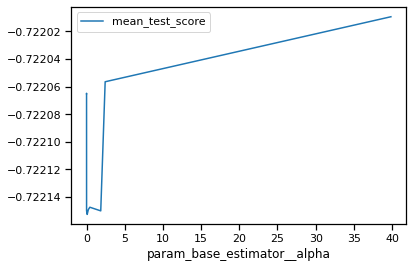

time: 761 ms


In [11]:
print(model.best_score_)
print(model.best_params_)
results_df = (
    pd.DataFrame(model.cv_results_)
    .sort_values(by="param_base_estimator__alpha", ascending=True)
    .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
)
results_df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

In [12]:
df = pd.DataFrame(model.cv_results_)
df.param_base_estimator__class_weight = df.param_base_estimator__class_weight.astype(
    str
)
df.groupby("param_base_estimator__class_weight").mean()

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,split5_test_score,split6_test_score,split7_test_score,mean_test_score,std_test_score,rank_test_score
param_base_estimator__class_weight,,,,,,,,,,,,,,,
None,0.676436,0.133283,0.084890,0.028650,-0.933527,-0.627578,-0.617376,-0.792053,-0.697278,-0.698981,-0.721955,-0.687750,-0.722062,0.094754,3.000000
balanced,0.767511,0.103087,0.088411,0.031429,-0.935261,-0.629077,-0.618634,-0.792469,-0.695159,-0.700104,-0.720137,-0.686198,-0.722130,0.095033,6.571429


time: 37 ms


In [13]:
def tune(alpha: Sequence, results_df: pd.DataFrame, n_iter: int = 10) -> pd.DataFrame:
    """Run tuning procedure"""
    model = RandomizedSearchCV(
        estimator=CalibratedClassifierCV(
            base_estimator=RidgeClassifier(random_state=SEED + 1, class_weight=None),
            method="isotonic",
            n_jobs=-1,
        ),
        param_distributions={"base_estimator__alpha": alpha},
        n_iter=n_iter,
        scoring="neg_log_loss",
        n_jobs=-1,
        cv=list(cross_validator()),
        verbose=1,
        random_state=SEED + 2,
        error_score="raise",
    ).fit(data, labels.valence)

    print("best score:", model.best_score_)
    print("best params:", model.best_params_)
    df = (
        pd.DataFrame(model.cv_results_)
        .sort_values(by="param_base_estimator__alpha", ascending=True)
        .loc[:, ["param_base_estimator__alpha", "mean_test_score"]]
    )
    df.plot(x="param_base_estimator__alpha", y="mean_test_score")
    plt.show()
    return pd.concat(
        [results_df.loc[:, ["param_base_estimator__alpha", "mean_test_score"]], df],
        axis="rows",
    )


_ = gc_collect()

time: 166 ms


Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7219608398969626
best params: {'base_estimator__alpha': 23.090900086512427}


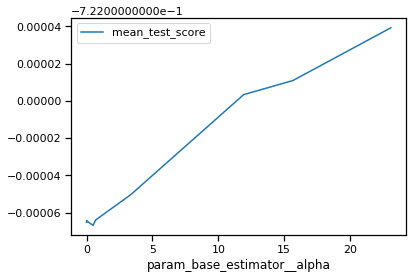

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7212942182371465
best params: {'base_estimator__alpha': 727.2411436844548}


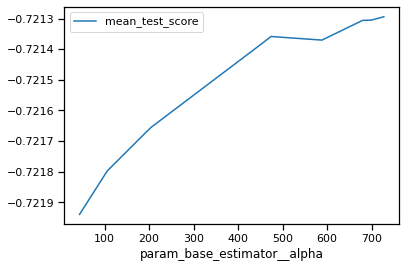

time: 23.7 s


In [14]:
df = tune(alpha=loguniform(1e-3, 1e3), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e-3, 1e3), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7220205930553539
best params: {'base_estimator__alpha': 8.108874421334596}


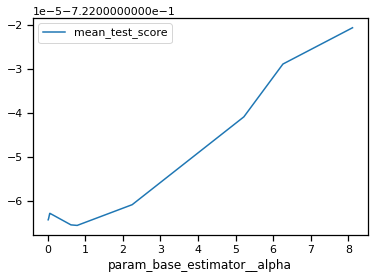

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7218804388541352
best params: {'base_estimator__alpha': 72.73401436844549}


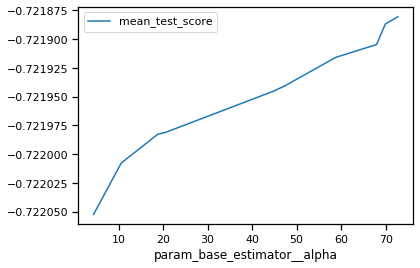

time: 22.2 s


In [15]:
df = tune(alpha=loguniform(1e-2, 1e2), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e-2, 1e2), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.722063990988668
best params: {'base_estimator__alpha': 0.04121514738188424}


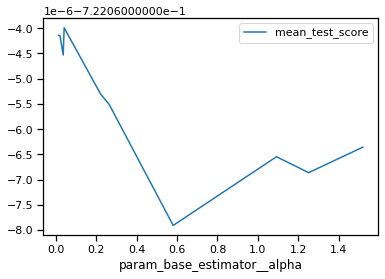

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7220209796299315
best params: {'base_estimator__alpha': 7.001087476815824}


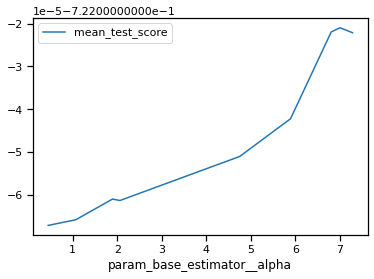

time: 21.8 s


In [16]:
df = tune(alpha=loguniform(1e-2, 10), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e-2, 10), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7220621056423054
best params: {'base_estimator__alpha': 0.11061360936306214}


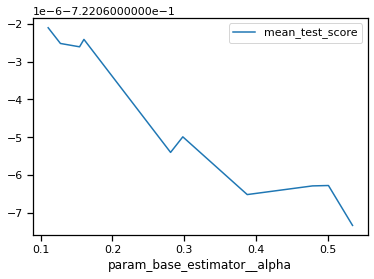

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7220617581387213
best params: {'base_estimator__alpha': 0.13942770737217836}


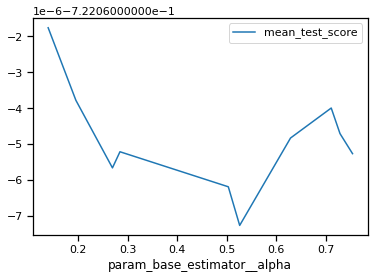

time: 22 s


In [17]:
df = tune(alpha=loguniform(0.1, 1), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.1, 0.9), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7220653467176228
best params: {'base_estimator__alpha': 0.6263093628798637}


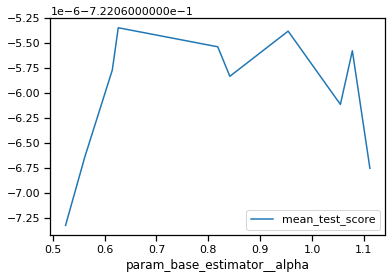

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7220637038004376
best params: {'base_estimator__alpha': 0.7050189523942888}


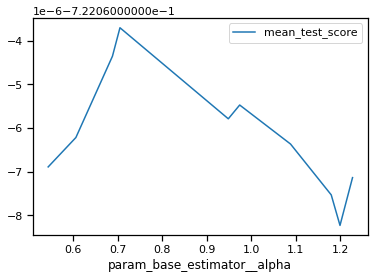

time: 22.4 s


In [18]:
df = tune(alpha=loguniform(0.5, 1.5), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.5, 1.0), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7220643841170218
best params: {'base_estimator__alpha': 0.9121672629709177}


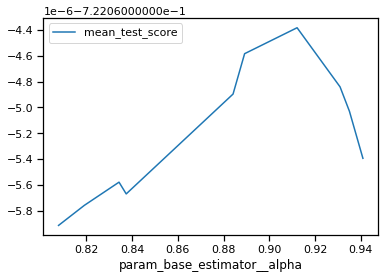

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7220638318474057
best params: {'base_estimator__alpha': 0.9176029037790796}


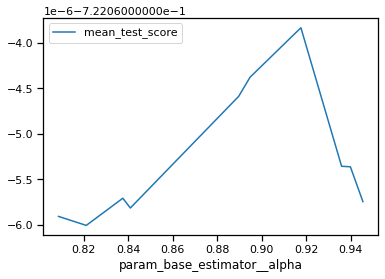

time: 22.7 s


In [19]:
df = tune(alpha=loguniform(0.8, 1.0), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.8, 0.2), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7220638521386074
best params: {'base_estimator__alpha': 0.919360642005174}


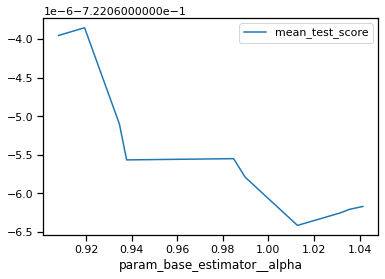

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7220639547346523
best params: {'base_estimator__alpha': 0.908761712749373}


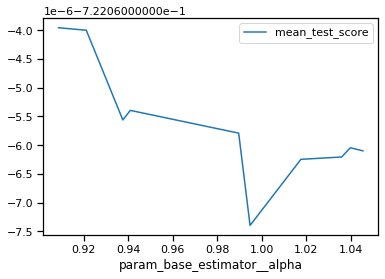

time: 21.6 s


In [20]:
df = tune(alpha=loguniform(0.9, 1.1), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.9, 0.2), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7210836045959532
best params: {'base_estimator__alpha': 1192.3483118324452}


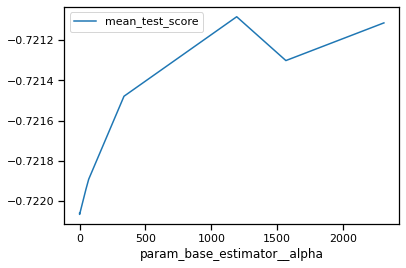

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7171654695061486
best params: {'base_estimator__alpha': 47384.67034082185}


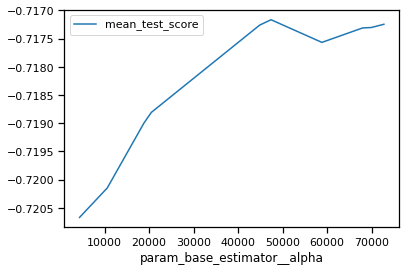

time: 20.9 s


In [21]:
df = tune(alpha=loguniform(0.1, 1e5), results_df=df, n_iter=10)
df = tune(alpha=uniform(0.1, 1e5), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7171096058982533
best params: {'base_estimator__alpha': 108308.46985724186}


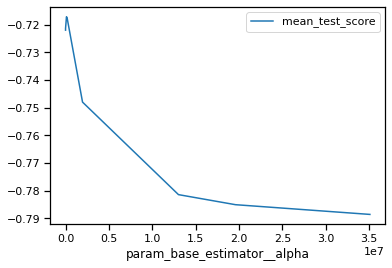

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7931792577976242
best params: {'base_estimator__alpha': 438085647.46864814}


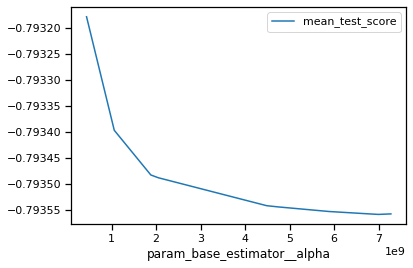

time: 21.5 s


In [22]:
df = tune(alpha=loguniform(10, 1e10), results_df=df, n_iter=10)
df = tune(alpha=uniform(10, 1e10), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7165391517315558
best params: {'base_estimator__alpha': 87110.91880089794}


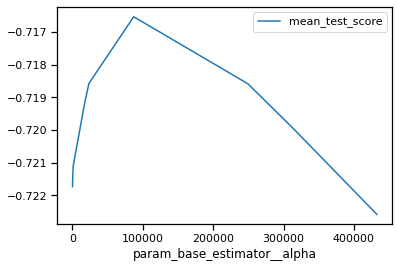

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7226838759936927
best params: {'base_estimator__alpha': 438185.63746864814}


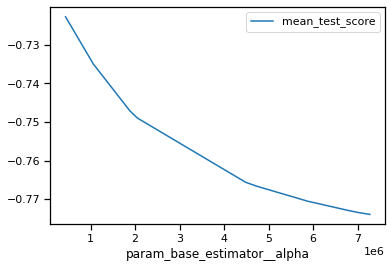

time: 21.5 s


In [23]:
df = tune(alpha=loguniform(100, 1e7), results_df=df, n_iter=10)
df = tune(alpha=uniform(100, 1e7), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7171001142619926
best params: {'base_estimator__alpha': 125119.85806183064}


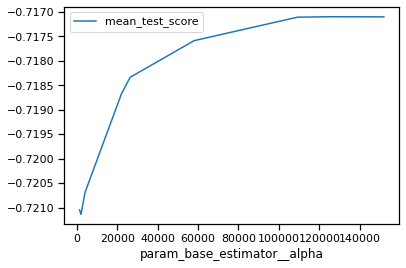

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7168167734287623
best params: {'base_estimator__alpha': 107062.87447626573}


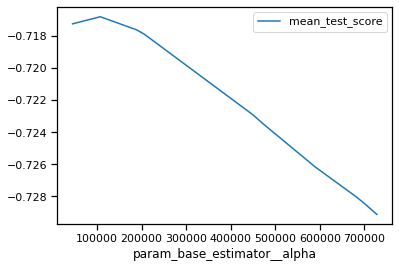

time: 21.8 s


In [24]:
df = tune(alpha=loguniform(1000, 1e6), results_df=df, n_iter=10)
df = tune(alpha=uniform(1000, 1e6), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7169797828201997
best params: {'base_estimator__alpha': 127662.36171261083}


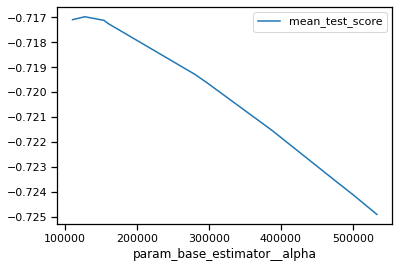

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7170559193162371
best params: {'base_estimator__alpha': 143808.56374686482}


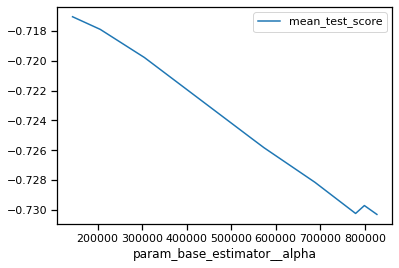

time: 20.4 s


In [25]:
df = tune(alpha=loguniform(1e5, 1e6), results_df=df, n_iter=10)
df = tune(alpha=uniform(1e5, 1e6), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7166035892715977
best params: {'base_estimator__alpha': 84037.33656295213}


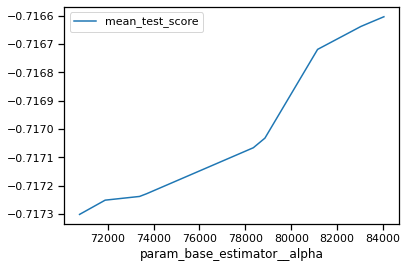

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7165234780188928
best params: {'base_estimator__alpha': 88451.705715486}


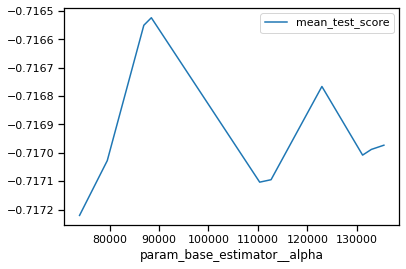

time: 26 s


In [26]:
df = tune(alpha=loguniform(70000, 90000), results_df=df, n_iter=10)
df = tune(alpha=uniform(70000, 90000), results_df=df, n_iter=10)

Fitting 8 folds for each of 11 candidates, totalling 88 fits
best score: -0.7164801202705724
best params: {'base_estimator__alpha': 90649.73738847037}


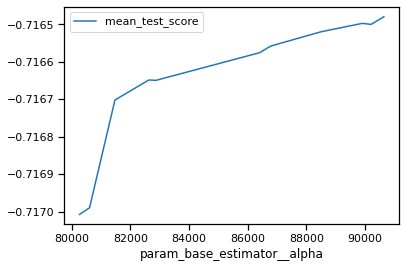

Fitting 8 folds for each of 11 candidates, totalling 88 fits
best score: -0.7164314791462612
best params: {'base_estimator__alpha': 97874.43620365807}


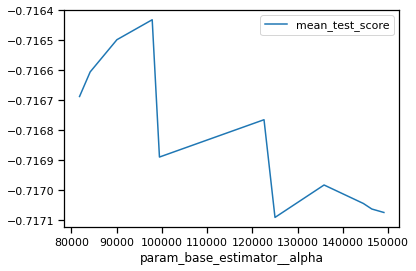

time: 23.8 s


In [27]:
df = tune(alpha=loguniform(80000, 95000), results_df=df, n_iter=11)
df = tune(alpha=uniform(80000, 95000), results_df=df, n_iter=11)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7164577378621626
best params: {'base_estimator__alpha': 95663.95159318387}


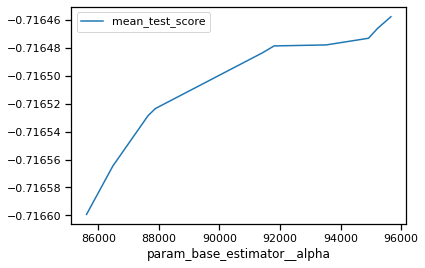

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7164513671247528
best params: {'base_estimator__alpha': 95606.28744762657}


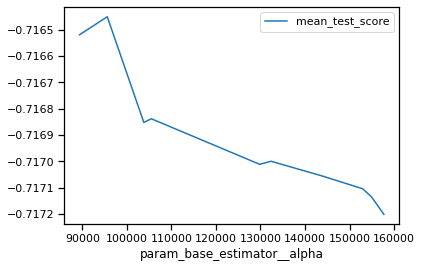

time: 21 s


In [28]:
df = tune(alpha=loguniform(85000, 100000), results_df=df, n_iter=10)
df = tune(alpha=uniform(85000, 100000), results_df=df, n_iter=10)

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.716440156031122
best params: {'base_estimator__alpha': 97167.08931863368}


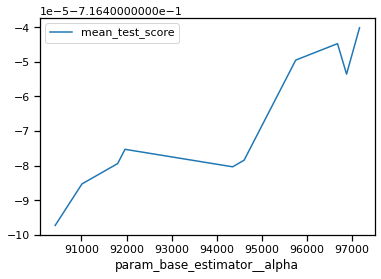

Fitting 8 folds for each of 10 candidates, totalling 80 fits
best score: -0.7164779198229876
best params: {'base_estimator__alpha': 94380.85637468648}


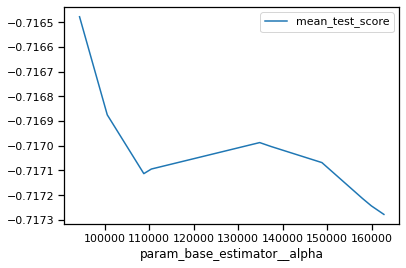

time: 20.4 s


In [29]:
df = tune(alpha=loguniform(90000, 100000), results_df=df, n_iter=10)
df = tune(alpha=uniform(90000, 100000), results_df=df, n_iter=10)

Fitting 8 folds for each of 15 candidates, totalling 120 fits
best score: -0.7164316104283246
best params: {'base_estimator__alpha': 97883.61012305082}


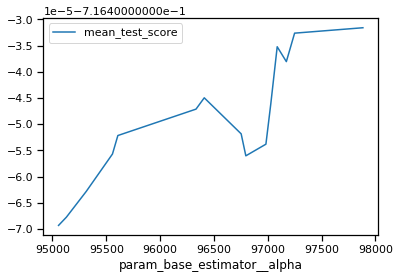

Fitting 8 folds for each of 15 candidates, totalling 120 fits
best score: -0.7164504942521434
best params: {'base_estimator__alpha': 99293.23924719275}


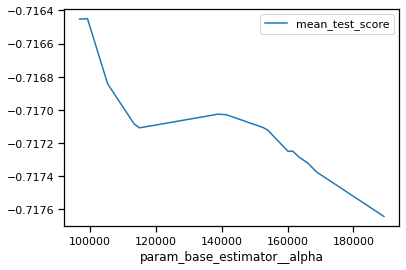

time: 28.9 s


In [30]:
df = tune(alpha=loguniform(95000, 98000), results_df=df, n_iter=15)
df = tune(alpha=uniform(95000, 98000), results_df=df, n_iter=15)

In [31]:
_ = gc_collect()

time: 130 ms


In [32]:
results_df = df
results_df.columns = results_df.columns.astype(str)
results_df.reset_index(drop=True).to_csv(f"{DATA_OUT_FOLDER}/ridge_results.csv")

time: 10 ms


<AxesSubplot:xlabel='param_base_estimator__alpha'>

,param_base_estimator__alpha,mean_test_score
2,97874.436204,-0.716431
13,97883.610123,-0.716432
11,97249.089086,-0.716433
1,97087.496043,-0.716435
6,97172.448011,-0.716438
6,97167.089319,-0.716440
7,96678.559865,-0.716445
8,96409.913426,-0.716445
7,97028.024848,-0.716446
9,96333.359586,-0.716447


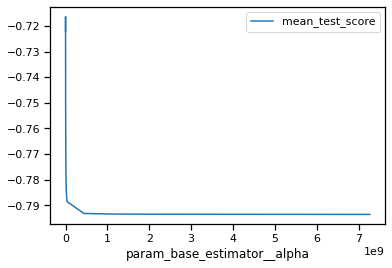

time: 353 ms


In [33]:
results_df = results_df.sort_values(by="param_base_estimator__alpha", ascending=True)
results_df.plot(x="param_base_estimator__alpha", y="mean_test_score")
df.sort_values(by="mean_test_score", ascending=False).head(100)

In [34]:
max_score = results_df.mean_test_score.max()
results_df.loc[results_df.mean_test_score == max_score]
results_df.loc[
    results_df.mean_test_score == max_score
].param_base_estimator__alpha.iloc[0]

,param_base_estimator__alpha,mean_test_score
2,97874.436204,-0.716431


97874.43620365807

time: 16 ms


<AxesSubplot:xlabel='param_base_estimator__alpha'>

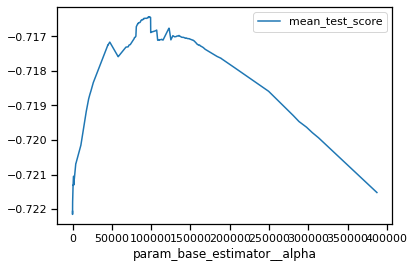

time: 202 ms


In [35]:
df = results_df.loc[results_df.param_base_estimator__alpha < 400000]
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

<AxesSubplot:xlabel='param_base_estimator__alpha'>

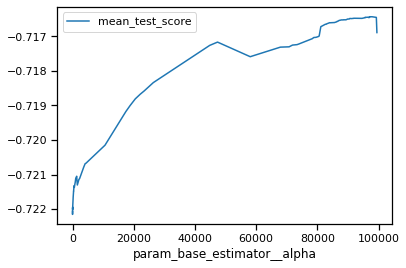

time: 163 ms


In [36]:
df = results_df.loc[results_df.param_base_estimator__alpha < 100000]
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

<AxesSubplot:xlabel='param_base_estimator__alpha'>

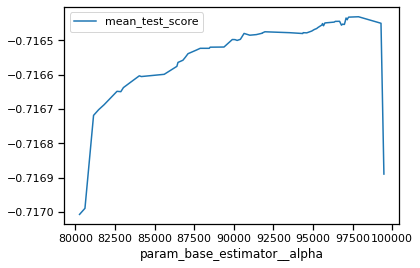

time: 202 ms


In [37]:
df = df.loc[df.param_base_estimator__alpha > 80000]
df.plot(x="param_base_estimator__alpha", y="mean_test_score")
plt.show()

# Discussion

There are so many more possibilities for feature engineering. Upstream augmentation of the raw audio would probably be helpful as would resampling.

It's important to be disciplined now and focus on deployment. Although there are numerous points of interest where tweaking is likely to yield better results, we are only deviating slightly from the feature engineering pathway we already established.

In [38]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 1102.3495078086853 s
time: 133 ms


[^top](#Contents)